In [2]:
import pandas as pd
import json
import pickle

# DATASET GOOGLE MAPS

## Sitios

Abrimos archivo "1.json"

In [3]:
df_Restaurant = pd.read_csv("C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\df_Restaurant.csv")

In [4]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\1.json"

datos = []
with open(archivo,"r") as archivo:
    for linea in archivo:
        objetos = json.loads(linea)
        datos.append(objetos)

df_sitios_1 = pd.DataFrame(datos)

Abrimos archivo "2.json"

In [5]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\2.json"

datos = []
with open(archivo,"r") as archivo:
    for linea in archivo:
        objetos = json.loads(linea)
        datos.append(objetos)

df_sitios_2 = pd.DataFrame(datos)


Abrimos archivo "3.json"

In [6]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\3.json"

datos = []
with open(archivo,"r") as archivo:
    for linea in archivo:
        objetos = json.loads(linea)
        datos.append(objetos)

df_sitios_3 = pd.DataFrame(datos)

Abrimos archivo "4.json"

In [7]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\4.json"

import json
import pandas as pd
datos = []
with open(archivo,"r") as archivo:
    for linea in archivo:
        objetos = json.loads(linea)
        datos.append(objetos)

df_sitios_4 = pd.DataFrame(datos)

Abrimos archivo "5.json"

In [8]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\5.json"
datos = []

with open(archivo, "r") as file:
    for linea in file:
        try:
            data = json.loads(linea)
            datos.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

df_sitios_5 = pd.DataFrame(datos)

Abrimos archivo "6.json"

In [9]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\6.json"

import json
import pandas as pd
datos = []
with open(archivo,"r") as archivo:
    for linea in archivo:
        objetos = json.loads(linea)
        datos.append(objetos)

df_sitios_6 = pd.DataFrame(datos)

Abrimos archivo "7.json"

In [10]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\7.json"
datos = []

with open(archivo, "r") as file:
    for linea in file:
        try:
            data = json.loads(linea)
            datos.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

df_sitios_7 = pd.DataFrame(datos)

Abrimos archivo "8.json"

In [11]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\8.json"
datos = []

with open(archivo, "r") as file:
    for linea in file:
        try:
            data = json.loads(linea)
            datos.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

df_sitios_8  = pd.DataFrame(datos)

Abrimos archivo "9.json"

In [12]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\9.json"
datos = []

with open(archivo, "r") as file:
    for linea in file:
        try:
            data = json.loads(linea)
            datos.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

df_sitios_9  = pd.DataFrame(datos)

Abrimos archivo "10.json"

In [13]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\10.json"
datos = []

with open(archivo, "r") as file:
    for linea in file:
        try:
            data = json.loads(linea)
            datos.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

df_sitios_10  = pd.DataFrame(datos)

Abrimos archivo "11.json"

In [14]:
archivo = "C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\metadata-sitios\\11.json"
datos = []

with open(archivo, "r") as file:
    for linea in file:
        try:
            data = json.loads(linea)
            datos.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

df_sitios_11  = pd.DataFrame(datos)

Concatenamos los dataframe

In [15]:
sitios = [df_sitios_1, df_sitios_2, df_sitios_3, df_sitios_4, df_sitios_5, df_sitios_6, df_sitios_7, df_sitios_8,df_sitios_9,df_sitios_10,df_sitios_11]
df_sitios = pd.concat(sitios, ignore_index=True)

In [5]:
df_Restaurant = pd.read_csv("C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\df_Restaurant.csv")

In [7]:
# Renombramos los nulos de la columna "category"
df_sitios['category'] = df_sitios['category'].fillna('')

# Filtramos bussines que sean restaurantes
df_Restaurant = df_sitios[df_sitios['category'].astype(str).str.contains('Restaurant', case=False)]

Cantidad de restaurantes en Florida exceptuando Miami, Fort Laureald , Miami Gardens

In [9]:
# Filtramos el estado de florida con la columna "address" 
df_Florida_Google = df_Restaurant[df_Restaurant["address"].str.contains("FL",na=False)]

# Ciudades que no hay que filtrar
Ciudades = ['Fort Lauderdale', 'Miami', 'Miami Gardens',"Boca Raton"]

# Filtrar las filas que contienen los términos definidos
filtrados = df_Florida_Google[df_Florida_Google['address'].str.contains('|'.join(Ciudades), case=False)]

# Obtener las filas no filtradas del DataFrame original
df_Florida_Google = df_Florida_Google[~df_Florida_Google.index.isin(filtrados.index)]
df_Florida_Google.count()

Unnamed: 0          5031
name                5031
address             5031
gmap_id             5031
description         1382
latitude            5031
longitude           5031
category            5031
avg_rating          5031
num_of_reviews      5031
price               1680
hours               4300
MISC                5004
state               4318
relative_results    3523
url                 5031
dtype: int64

Existen 5031 restaurantes en florida exceptuando Fort Lauderdale, Miami, Miami Gardens y Boca Raton

top 5 mayores restaurantes

In [11]:
top_5_restaurantes = df_Florida_Google["category"].value_counts().head(5)
top_5_restaurantes

category
['Restaurant']                                                                              1292
['Pizza restaurant']                                                                         142
['Mexican restaurant']                                                                       136
['Sandwich shop', 'Caterer', 'Fast food restaurant', 'Takeout Restaurant', 'Restaurant']     105
['American restaurant']                                                                       85
Name: count, dtype: int64

Los retaurantes mas predominante son de pizza, mexicano, fast food, americano

In [12]:
grupo_categorias = df_Florida_Google.groupby('category')['avg_rating'].sum().reset_index()
top_categorias = grupo_categorias.sort_values(by='avg_rating', ascending=False).head(5)
top_categorias



,category,avg_rating
1344,['Restaurant'],5464.2
982,['Mexican restaurant'],581.7
1119,['Pizza restaurant'],580.1
1364,"['Sandwich shop', 'Caterer', 'Fast food restau...",399.4
70,['American restaurant'],360.7


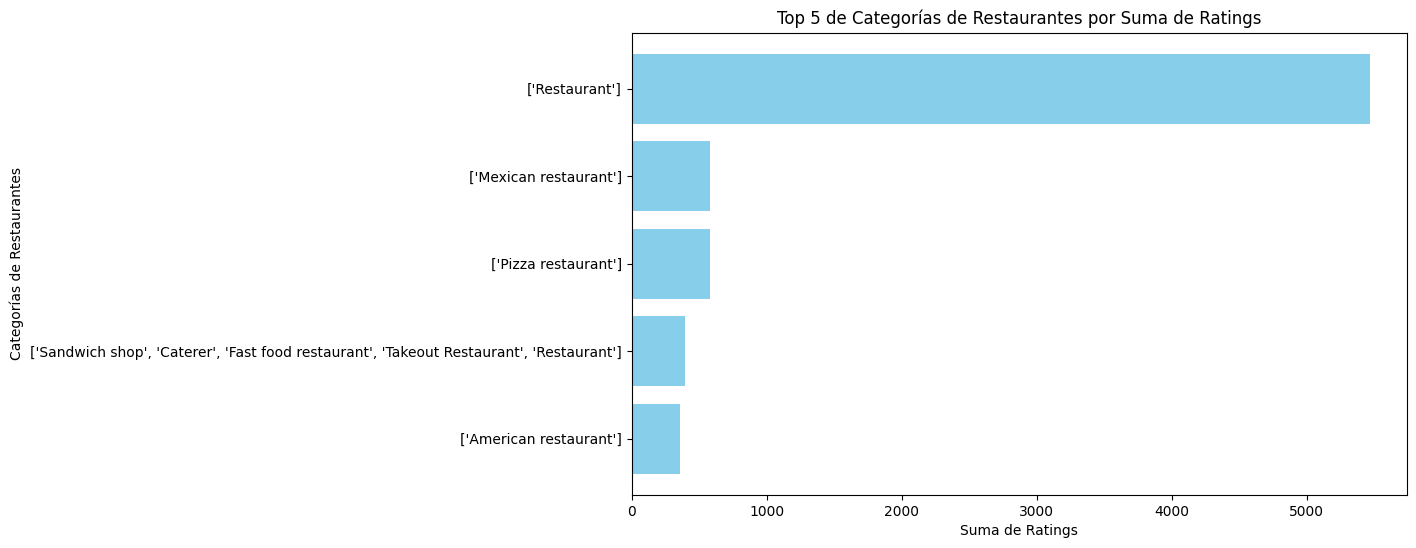

In [13]:
import matplotlib.pyplot as plt

# Suponiendo que 'top_categorias' es el DataFrame con el top 5 de categorías y sus sumas de rating
plt.figure(figsize=(10, 6))
plt.barh(top_categorias['category'], top_categorias['avg_rating'], color='skyblue')
plt.xlabel('Suma de Ratings')
plt.ylabel('Categorías de Restaurantes')
plt.title('Top 5 de Categorías de Restaurantes por Suma de Ratings')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la categoría con mayor rating en la parte superior
plt.show()


Los restaurantes con mejores calificaciones que aceptan pagos con tarjeta de crédito

In [58]:
# Restaurantes que aceptan tarjeta de credito
Tarjeta_credito = df_Florida_Google[df_Florida_Google['MISC'].str.contains("Credit Car", case=False)]


In [68]:
# Agrupamos por "category" y "MISC", sumando la columna 'avg_rating'
Tarjeta_credito = Tarjeta_credito.groupby(['category',"MISC"])['avg_rating'].sum().reset_index()
# Ordenamos los 5 mejores puntajes
Tarjeta_credito = Tarjeta_credito.sort_values(by='avg_rating', ascending=False)
top_5_restaurante_credito = Tarjeta_credito.head(5)
top_5_restaurante_credito

,category,MISC,avg_rating
139,"['Convenience store', 'Breakfast restaurant', ...","{'Service options': ['Curbside pickup', 'No-co...",14.4
391,"['Pizza restaurant', 'Hamburger restaurant', '...","{'Service options': ['Outdoor seating', 'Takeo...",10.0
465,"['Restaurant', 'Colombian restaurant']","{'Service options': ['Outdoor seating', 'Curbs...",9.8
419,['Puerto Rican restaurant'],"{'Service options': ['Takeout', 'Dine-in', 'De...",9.2
325,"['Juice shop', 'Health food restaurant']","{'Service options': ['No-contact delivery', 'D...",8.4


In [82]:
# Renomnramos categorias
renombrar_categorias = {
    "['Convenience store', 'Breakfast restaurant', 'Cafe', 'Candy store', 'Cheesesteak restaurant', 'Coffee shop', 'Fast food restaurant', 'Gas station', 'Hoagie restaurant', 'Sandwich shop']": 'Desayuno/Gasolinera/Golosinas',
    "['Pizza restaurant', 'Hamburger restaurant', 'Sandwich shop']": 'Pizza/Hamburguesa',
    "['Restaurant', 'Colombian restaurant']": "Restaurante colombiano",
    "['Puerto Rican restaurant']" : "Restaurante puertoriqueño",
    "['Juice shop', 'Health food restaurant']": 'Comida Saludable/Jugos'
}

# Reemplazar los nombres de las categorías en el DataFrame
top_5_restaurante_credito['category'] = top_5_restaurante_credito['category'].replace(renombrar_categorias)

C:\Users\Giuliano\AppData\Local\Temp\ipykernel_2852\1602191131.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_restaurante_credito['category'] = top_5_restaurante_credito['category'].replace(renombrar_categorias)


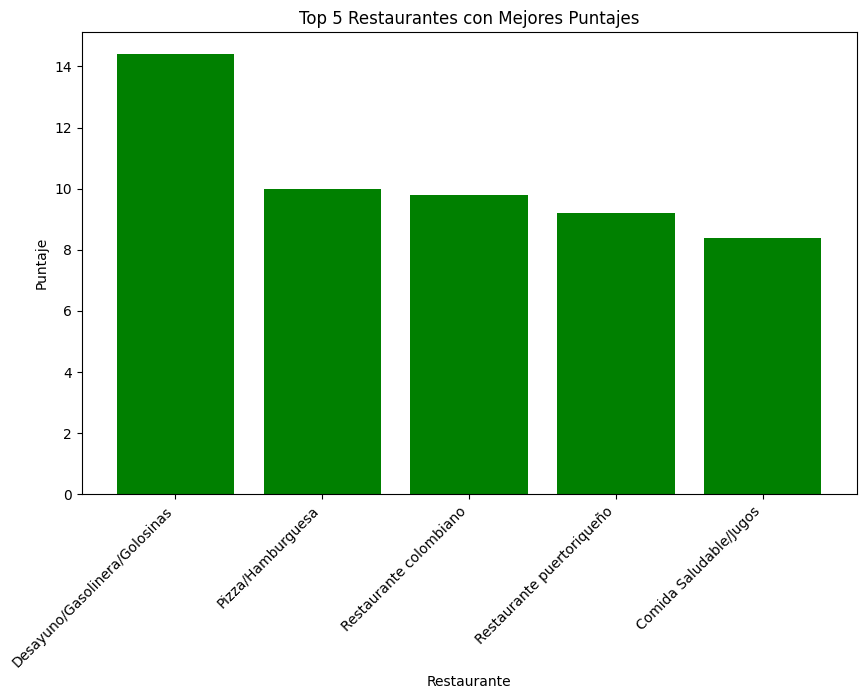

In [85]:
plt.figure(figsize=(10, 6))
plt.bar(top_5_restaurante_credito['category'], top_5_restaurante_credito["avg_rating"], color='green')
plt.title('Top 5 Restaurantes con Mejores Puntajes')
plt.xlabel('Restaurante')
plt.ylabel('Puntaje')
plt.xticks(rotation=45, ha='right')


# Mostrar el gráfico
plt.show()

Los restaurantes mejor valorados que aceptan tarjeta de credito

 Restaurante que tienen servicio de delivery

In [14]:
# Rellenamos valores faltantes
df_Florida_Google['MISC'].fillna('', inplace=True)
# Observamos los restaurantes que tienen dleivery
delivery = df_Florida_Google[df_Florida_Google['MISC'].str.contains("Delivery", case=False)]
delivery["MISC"].count()

4457

4457 restaurantes tienen servicio de delivery

Grafico Circular, Porcentaje de Restaurantes con y sin Servicio de Delivery en Florida

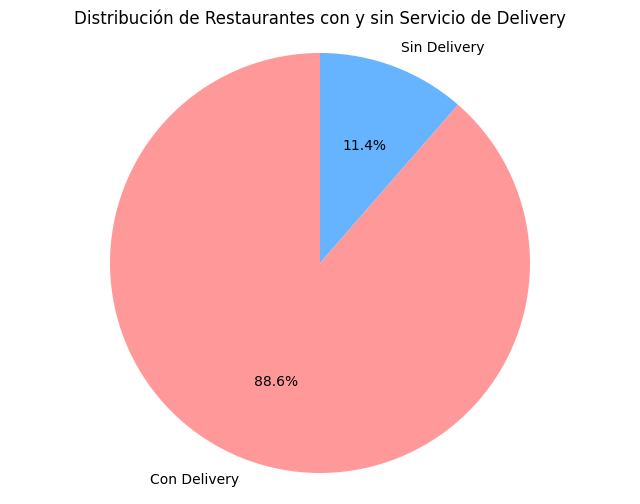

In [15]:
import matplotlib.pyplot as plt

# Datos
total_restaurantes = 5031
con_delivery = 4457
sin_delivery = total_restaurantes - con_delivery

# Etiquetas y valores para el gráfico
etiquetas = ['Con Delivery', 'Sin Delivery']
valores = [con_delivery, sin_delivery]
colores = ['#ff9999','#66b3ff']

# Crear gráfico de torta
plt.figure(figsize=(8, 6))
plt.pie(valores, labels=etiquetas, colors=colores, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Restaurantes con y sin Servicio de Delivery')
plt.axis('equal')  # Hace que el gráfico sea un círculo en lugar de una elipse

# Mostrar el gráfico
plt.show()


Concatenamos 11 archivos JSON en 'metadata-sitios', se procedió a filtrar los 5031 restaurantes en Florida, excluyendo Fort Lauderdale, Miami, Miami Gardens y Boca Raton. De este conjunto, un 88.6% ofrece servicio de entrega a domicilio. La categoría más valorada que acepta tarjeta de crédito es la de Desayuno/Gasolinera/Golosinas. Entre las categorías con mejores puntajes se destacan los restaurantes de pizza, comida mexicana, locales de comida rápida y cocinas estadounidenses.

Considerando estos datos, explorar la inversión en un restaurante con estas tendencias puede tener resultados.

## Reviews-Florida

In [ ]:
datos = []
with open('C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\review_Florida\\8.json',"r",encoding="utf-8") as archivo:
    for linea in archivo:
        objeto_json = json.loads(linea)
        datos.append(objeto_json)

df_review_8 = pd.DataFrame(datos)


In [ ]:
datos = []
with open('C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\review_Florida\\10.json',"r",encoding="utf-8") as archivo:
    for linea in archivo:
        objeto_json = json.loads(linea)
        datos.append(objeto_json)

df_review_10 = pd.DataFrame(datos)


In [ ]:
datos = []
with open('C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\review_Florida\\11.json',"r",encoding="utf-8") as archivo:
    for linea in archivo:
        objeto_json = json.loads(linea)
        datos.append(objeto_json)

df_review_11 = pd.DataFrame(datos)


In [ ]:
datos = []
with open('C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\review_Florida\\14.json',"r",encoding="utf-8") as archivo:
    for linea in archivo:
        objeto_json = json.loads(linea)
        datos.append(objeto_json)

df_review_14 = pd.DataFrame(datos)

In [ ]:
datos = []
with open('C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\review_Florida\\17.json',"r",encoding="utf-8") as archivo:
    for linea in archivo:
        objeto_json = json.loads(linea)
        datos.append(objeto_json)

df_review_17 = pd.DataFrame(datos)

In [ ]:
datos = []
with open('C:\\Users\\Giuliano\\Desktop\\Proyecto grupal\\Google maps\\review_Florida\\18.json',"r",encoding="utf-8") as archivo:
    for linea in archivo:
        objeto_json = json.loads(linea)
        datos.append(objeto_json)

df_review_18 = pd.DataFrame(datos)

In [ ]:
merge_1 = pd.merge(df_review_8,df_review_10,on="user_id",how="inner")
merge_2 = pd.merge(merge_1,df_review_11,on="user_id",how="inner")

In [ ]:
lista= ["name_x","time_x","rating_x","text_x","pics_x","resp_x","gmap_id_x","name_y","time_y","rating_y","text_y","pics_y","resp_y","gmap_id_y"]
merge_2 = merge_2.drop(columns=lista)

In [ ]:
merge_3 = pd.merge(merge_2,df_review_14,on="user_id",how="inner")
merge_4 = pd.merge(merge_3,df_review_17,on="user_id",how="inner")

In [ ]:
lista= ["name_x","time_x","rating_x","text_x","pics_x","resp_x","gmap_id_x","name_y","time_y","rating_y","text_y","pics_y","resp_y","gmap_id_y"]
merge_4 = merge_4.drop(columns=lista)
merge_5 = pd.merge(merge_4,df_review_18,on="user_id",how="inner")

In [ ]:
lista= ["name_y","time_y","rating_y","text_y","pics_y","resp_y","gmap_id_y"]
df_reviews_maps = merge_5.drop(columns=lista)

In [ ]:
df_reviews_maps.to_csv("df_reviews_maps.csv")

In [ ]:
pd.read_csv("df_reviews_maps.csv")

C:\Users\Giuliano\AppData\Local\Temp\ipykernel_7176\3646677170.py:1: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("df_reviews_maps.csv")


,Unnamed: 0,user_id,name_x,time_x,rating_x,text_x,pics_x,resp_x,gmap_id_x
0,0,101979910797375182031,Li Zephyr,1583346035826,5,NaN,NaN,NaN,0x88e77c4a94a8278b:0x391d52e0b192f1d3
1,1,113992450246527333718,Erik Kling,1476977652621,5,NaN,NaN,NaN,0x88d0d94e5f4a099d:0x6f78101fcc3b6ed7
2,2,113992450246527333718,Erik Kling,1476977652621,5,NaN,NaN,NaN,0x88d0d94e5f4a099d:0x6f78101fcc3b6ed7
3,3,113992450246527333718,Erik Kling,1476977652621,5,NaN,NaN,NaN,0x88d0d94e5f4a099d:0x6f78101fcc3b6ed7
4,4,113992450246527333718,Erik Kling,1476977652621,5,NaN,NaN,NaN,0x88d0d94e5f4a099d:0x6f78101fcc3b6ed7
...,...,...,...,...,...,...,...,...,...
1427576,1427576,114197646375603773697,Adrian Oropeza,1600984670010,5,"Outstanding quality, service, honesty, prices ...",NaN,NaN,0x88d908719a5ea8c9:0xbd0669172d9fb0b2
1427577,1427577,114197646375603773697,Adrian Oropeza,1600984670010,5,"Outstanding quality, service, honesty, prices ...",NaN,NaN,0x88d908719a5ea8c9:0xbd0669172d9fb0b2
1427578,1427578,114197646375603773697,Adrian Oropeza,1600984670010,5,"Outstanding quality, service, honesty, prices ...",NaN,NaN,0x88d908719a5ea8c9:0xbd0669172d9fb0b2
1427579,1427579,114197646375603773697,Adrian Oropeza,1600984670010,5,"Outstanding quality, service, honesty, prices ...",NaN,NaN,0x88d908719a5ea8c9:0xbd0669172d9fb0b2


In [ ]:
df_reviews_maps

,Unnamed: 0,user_id,name_x,time_x,rating_x,text_x,pics_x,resp_x,gmap_id_x
0,0,101979910797375182031,Li Zephyr,1583346035826,5,NaN,NaN,NaN,0x88e77c4a94a8278b:0x391d52e0b192f1d3
1,1,113992450246527333718,Erik Kling,1476977652621,5,NaN,NaN,NaN,0x88d0d94e5f4a099d:0x6f78101fcc3b6ed7
2,2,113992450246527333718,Erik Kling,1476977652621,5,NaN,NaN,NaN,0x88d0d94e5f4a099d:0x6f78101fcc3b6ed7
3,3,113992450246527333718,Erik Kling,1476977652621,5,NaN,NaN,NaN,0x88d0d94e5f4a099d:0x6f78101fcc3b6ed7
4,4,113992450246527333718,Erik Kling,1476977652621,5,NaN,NaN,NaN,0x88d0d94e5f4a099d:0x6f78101fcc3b6ed7
...,...,...,...,...,...,...,...,...,...
1427576,1427576,114197646375603773697,Adrian Oropeza,1600984670010,5,"Outstanding quality, service, honesty, prices ...",NaN,NaN,0x88d908719a5ea8c9:0xbd0669172d9fb0b2
1427577,1427577,114197646375603773697,Adrian Oropeza,1600984670010,5,"Outstanding quality, service, honesty, prices ...",NaN,NaN,0x88d908719a5ea8c9:0xbd0669172d9fb0b2
1427578,1427578,114197646375603773697,Adrian Oropeza,1600984670010,5,"Outstanding quality, service, honesty, prices ...",NaN,NaN,0x88d908719a5ea8c9:0xbd0669172d9fb0b2
1427579,1427579,114197646375603773697,Adrian Oropeza,1600984670010,5,"Outstanding quality, service, honesty, prices ...",NaN,NaN,0x88d908719a5ea8c9:0xbd0669172d9fb0b2
